<a href="https://colab.research.google.com/github/natrask/ENM5320/blob/main/Code/CNN_stencil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See if we can learn a nonlinear operator - how about
$$L[u] = \partial_x u^2$$
which is representative of a nonlinear advection term like you would get in the Navier-Stokes equations.

For a given mode $u(x,t) = \sin(kx)$, we should recover
$$L[u] = \partial_x u^2 = 2 u \partial_x u = 2k \sin(kx) \cos(kx) = k \sin(\frac{kx}{2})$$

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model (in our case, its y = A*x + b)
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # Magnitude of diffusion operator to stabilize stencil
        self.logstabilizer = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        self.stabilizer = torch.exp(self.logstabilizer)

        # Construct nonlinear network
        layers = []
        # Input layer
        layers.append(nn.Linear(self.Nstencil, hidden_dim, dtype=torch.float64))
        layers.append(nn.Tanh())  # Activation function
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim, dtype=torch.float64))
            layers.append(nn.Tanh())
        # Output layer
        output_layer = nn.Linear(hidden_dim, self.Nstencil, dtype=torch.float64)
        output_layer.weight.data.fill_(0.0)  # Set weights to zero
        output_layer.bias.data.fill_(0.0)  # Set bias to zero (if any)
        layers.append(output_layer)

        self.nonlinear_network = nn.Sequential(*layers)

    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # # Apply MLP layer to stencil
          nonlinear_output = self.nonlinear_network(xstencil)

          # Compute d2dx2 = D_+*D_- x = h^{-2}*(ujm1 - 2 uj + ujp1)
          D2x = h**(-2)*(x[(i-1)%(N_nodes-1)] - 2*x[i] + x[(i+1)%(N_nodes-1)])

          # Apply stencil
          f_out[i] = torch.sum(nonlinear_output * xstencil) + self.stabilizer*D2x
          # f_out[i] = self.stabilizer*D2x

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

# Parameters
L = 2.0*np.pi  # Length of the domain
T = np.pi   # Total time
nx = 50  # Number of spatial points
nt = 50  # Number of time steps

# Discretization
dx = L / nx
dt = T / nt
x = torch.from_numpy(np.linspace(0, L, nx))
Dx = FiniteDifferenceOperator(1,1,3,5)  # Finite difference operator w a neighbor on either side

# Define a single mode
def getData(x,k):
  return torch.sin(k*x)
def getLabel(x,k):
  return k*torch.cos(k*x)
  # return k*torch.sin(k*x/2.)

# Define the optimizer so that it optmizes over stencil parameters
optimizer = optim.Adam(Dx.parameters(), lr=0.01)

num_epochs = 1000
for epoch in range(num_epochs):

    # Clear gradients
    optimizer.zero_grad()

    # Pick a random wavenumber
    k = 1
    un = getData(x,k)
    Lun = getLabel(x,k)
    dudt_learned = Dx(un,dx)
    loss = torch.mean((Lun-dudt_learned)**2)

    # Backward pass and optimization
    loss.backward(retain_graph=True)
    optimizer.step()


    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')


Epoch [1/1000], Loss: 1.0397872070773129
Epoch [101/1000], Loss: 0.05803811637795953
Epoch [201/1000], Loss: 5.0951675408723935e-06
Epoch [301/1000], Loss: 2.1610961955949917e-06
Epoch [401/1000], Loss: 1.973814287808614e-06
Epoch [501/1000], Loss: 1.8812795036117282e-06
Epoch [601/1000], Loss: 1.8266518011756676e-06


KeyboardInterrupt: 

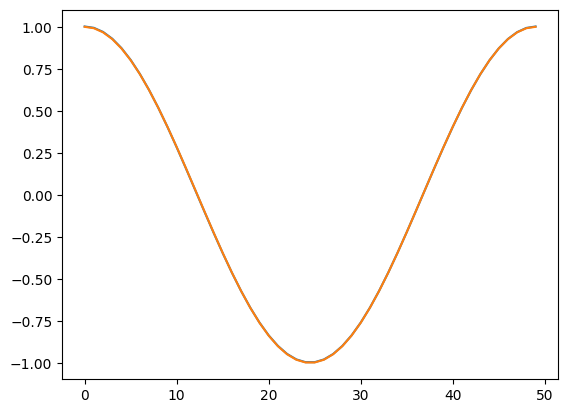

In [69]:
sol = Dx(getData(x,1),dx)
plt.plot(sol.detach().numpy())
true = getLabel(x,1)
plt.plot(true.detach().numpy())


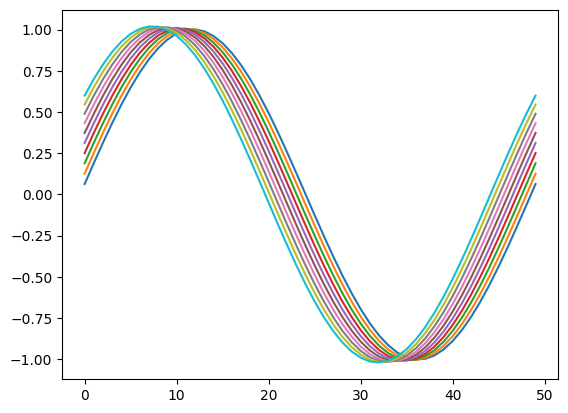

In [70]:
uinit = np.sin(2 * np.pi * x / L)  # Initial condition
un = uinit

for m in range(10):
  un = un + dt*Dx(un,dx)
  if m%1==0:
    plt.plot(un.detach().numpy())